In [2]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
import cv2
from glob import glob
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger


def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = attention_unet(input_shape)
    model.summary()

2024-07-27 15:03:02.706049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/juwumukiza/.local/lib/python3.10/site-packages/cv2/../../lib64:/opt/slurm/lib64:/home/yourusername/Train/multicompartmentSegmentation/multic/segmentationschool/BasicImageProcess/vips-8.10.6/lib:/opt/slurm/lib64:
2024-07-27 15:03:02.706391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/juwumukiza/.local/lib/python3.10/site-packages/cv2/../../lib64:/opt/slurm/lib64:/home/yourusername/Train/multicompartmentSegmentation/multic/segmentationschool/BasicImageProcess/vips-8.10.6/lib:/opt/slurm/lib64:
2024-07-27 15:03:02.706570: W tensorflow/stream_executor/platform/defaul

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                    

In [11]:
import cv2
import numpy as np
from glob import glob
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_data(image_paths, mask_paths, img_size):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load and preprocess the image
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        
        # Load and preprocess the mask as binary
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        mask = cv2.resize(mask, img_size)
        _, mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)
        mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension
        
        images.append(img)
        masks.append(mask)
        
    return np.array(images), np.array(masks)

def data_generator(image_paths, mask_paths, batch_size, img_size, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_image_paths = image_paths[i:i+batch_size]
            batch_mask_paths = mask_paths[i:i+batch_size]
            images, masks = load_data(batch_image_paths, batch_mask_paths, img_size)
            
            if augment:
                seed = np.random.randint(0, 10000)
                aug_images = datagen.flow(images, batch_size=batch_size, seed=seed, shuffle=True)
                aug_masks = datagen.flow(masks, batch_size=batch_size, seed=seed, shuffle=True)
                yield next(aug_images), next(aug_masks)
            else:
                yield images, masks

if __name__ == "__main__":
    img_size = (256, 256)
    batch_size = 8
    additional_epochs = 100

    train_image_paths = sorted(glob("./data/train/images/*"))
    train_mask_paths = sorted(glob("./data/train/masks/*"))
    val_image_paths = sorted(glob("./data/val/images/*"))
    val_mask_paths = sorted(glob("./data/val/masks/*"))

    train_gen = data_generator(train_image_paths, train_mask_paths, batch_size, img_size, augment=True)
    val_gen = data_generator(val_image_paths, val_mask_paths, batch_size, img_size, augment=False)

    model = attention_unet((*img_size, 3))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    
    callbacks = [
        EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
        ModelCheckpoint("attention_unet.h5", monitor='loss', save_best_only=True),
        ReduceLROnPlateau(monitor='loss', patience=5),
        CSVLogger("training_log.csv", append=True)
    ]

    # Debugging: Print the shapes of the data being generated
    for batch in train_gen:
        images, masks = batch
        print(f"Train batch images shape: {images.shape}")
        print(f"Train batch masks shape: {masks.shape}")
        break
    
    for batch in val_gen:
        images, masks = batch
        print(f"Validation batch images shape: {images.shape}")
        print(f"Validation batch masks shape: {masks.shape}")
        break

    model.fit(
        train_gen,
        steps_per_epoch=(len(train_image_paths) // batch_size) * 10,  # Augmenting to 10 times more images
        epochs=additional_epochs,  # Train for the additional epochs
        validation_data=val_gen,
        validation_steps=len(val_image_paths) // batch_size,
        callbacks=callbacks
    )


Train batch images shape: (8, 256, 256, 3)
Train batch masks shape: (8, 256, 256, 1)
Validation batch images shape: (6, 256, 256, 3)
Validation batch masks shape: (6, 256, 256, 1)
Epoch 1/100
10/10 [==============================] - 237s 24s/step - loss: 0.3022 - accuracy: 0.9433 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 236s 24s/step - loss: 0.1085 - accuracy: 0.9916 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 238s 24s/step - loss: 0.0749 - accuracy: 0.9911 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 237s 24s/step - loss: 0.0614 - accuracy: 0.9915 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 236s 24s/step - loss: 0.0535 - accuracy: 0.9914 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 236s 24s/step - loss: 0.0477 - accuracy: 0.9912 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 238s 24s/step - loss: 0.0431 - accuracy: 0.9914 - lr: 0.0010
Epoch 8/100
10/10 [===

Test Images Shape: (6, 256, 256, 3)
Test Masks Shape: (6, 256, 256, 1)
1/1 [==============================] - 5s 5s/step


/home/juwumukiza/.local/lib/python3.10/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


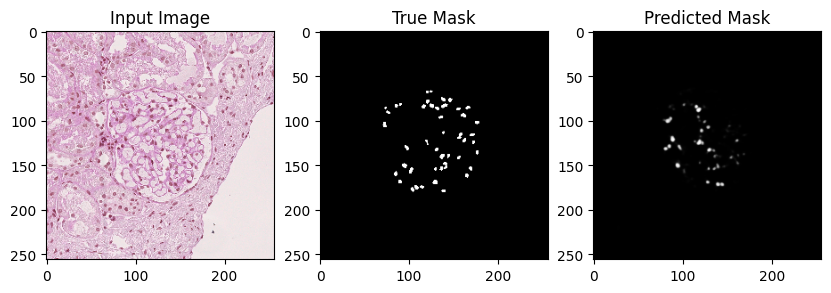

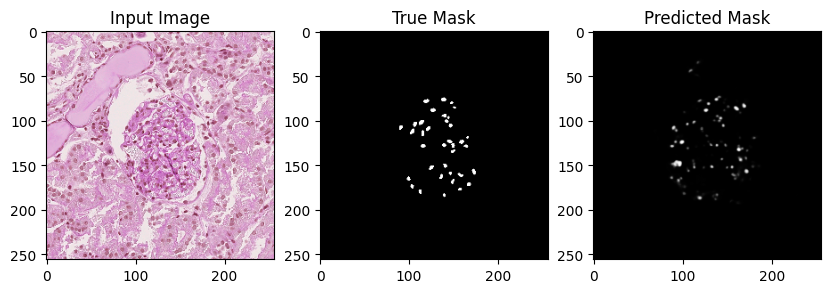

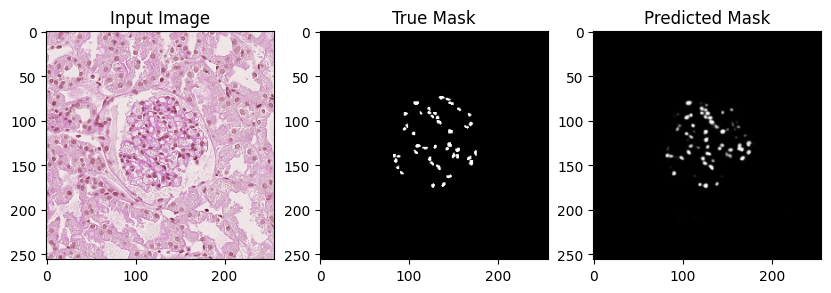

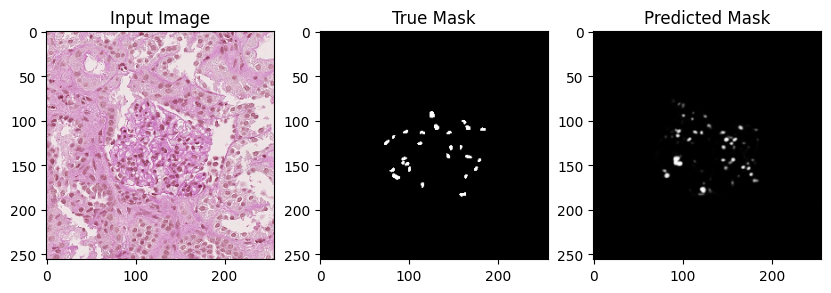

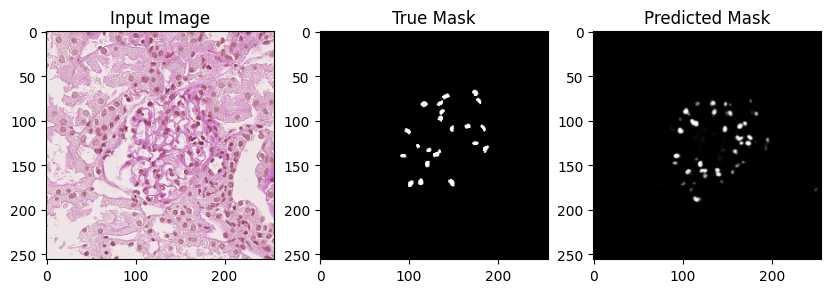

Average IoU: 0.1673250937691633
Average SSIM: 0.9740304829372671


In [13]:
import numpy as np
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import cv2
from glob import glob

# Enable eager execution
tf.config.run_functions_eagerly(True)

def load_data(image_paths, mask_paths, img_size):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        mask = cv2.resize(mask, img_size)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def calculate_iou(y_true, y_pred, threshold=0.5):
    y_pred_thresholded = y_pred > threshold
    y_true_thresholded = y_true > threshold
    intersection = np.logical_and(y_true_thresholded, y_pred_thresholded)
    union = np.logical_or(y_true_thresholded, y_pred_thresholded)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def test_model(model, test_image_paths, test_mask_paths, img_size):
    test_images, test_masks = load_data(test_image_paths, test_mask_paths, img_size)
    print(f"Test Images Shape: {test_images.shape}")
    print(f"Test Masks Shape: {test_masks.shape}")

    predictions = model.predict(test_images)
    ious = []
    ssims = []
    
    for i in range(len(test_images)):
        y_true = test_masks[i]
        y_pred = predictions[i]
        
        if y_true.shape != y_pred.shape:
            print(f"Shape mismatch: y_true {y_true.shape}, y_pred {y_pred.shape}")
            continue
        
        iou = calculate_iou(y_true, y_pred)
        ious.append(iou)
        
        ssim_index = ssim(y_true.squeeze(), y_pred.squeeze(), channel_axis=-1)
        ssims.append(ssim_index)
        
        # Display a few predictions
        if i < 5:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i])
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(y_true.squeeze(), cmap='gray')
            plt.title("True Mask")
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred.squeeze(), cmap='gray')
            plt.title("Predicted Mask")
            plt.show()
    
    avg_iou = np.mean(ious)
    avg_ssim = np.mean(ssims)
    print(f"Average IoU: {avg_iou}")
    print(f"Average SSIM: {avg_ssim}")
    return predictions

if __name__ == "__main__":
    img_size = (256, 256)

    test_image_paths = sorted(glob("./data/test/images/*"))
    test_mask_paths = sorted(glob("./data/test/masks/*"))

    # Assuming the model is already loaded and compiled
    predictions = test_model(model, test_image_paths, test_mask_paths, img_size)


In [2]:
import tensorflow as tf
import numpy as np
from glob import glob
import cv2

def custom_accuracy(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total = tf.size(y_true, out_type=tf.int32)
    return correct / tf.cast(total, tf.float32)

def load_data(image_paths, mask_paths, img_size):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load and preprocess the image
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        
        # Load and preprocess the mask as binary
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        mask = cv2.resize(mask, img_size)
        _, mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)
        mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension
        
        images.append(img)
        masks.append(mask)
        
    return np.array(images), np.array(masks)

def evaluate_model(model, test_image_paths, test_mask_paths, img_size):
    test_images, test_masks = load_data(test_image_paths, test_mask_paths, img_size)
    results = model.evaluate(test_images, test_masks, verbose=1)
    for name, value in zip(model.metrics_names, results):
        print(f"{name}: {value}")

if __name__ == "__main__":
    img_size = (256, 256)
    
    test_image_paths = sorted(glob("./data/test/images/*"))
    test_mask_paths = sorted(glob("./data/test/masks/*"))

    # Load the trained model
    model = tf.keras.models.load_model("attention_unet.h5", custom_objects={"custom_accuracy": custom_accuracy})

    # Compile the model with the custom accuracy metric
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[custom_accuracy])

    # Evaluate the model
    evaluate_model(model, test_image_paths, test_mask_paths, img_size)


1/1 [==============================] - 3s 3s/step - loss: 0.0457 - custom_accuracy: 0.9884
loss: 0.0456908755004406
custom_accuracy: 0.9883778691291809


In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
import cv2
from glob import glob

def load_data(image_paths, mask_paths, img_size):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        _, mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)
        mask = np.expand_dims(mask, axis=-1)
        
        images.append(img)
        masks.append(mask)
        
    return np.array(images), np.array(masks)

def evaluate_model(model, test_image_paths, test_mask_paths, img_size):
    test_images, test_masks = load_data(test_image_paths, test_mask_paths, img_size)
    predictions = model.predict(test_images)
    
    predictions = (predictions > 0.5).astype(np.uint8)
    test_masks = test_masks.astype(np.uint8)
    
    f1 = f1_score(test_masks.flatten(), predictions.flatten(), average='binary')
    precision = precision_score(test_masks.flatten(), predictions.flatten(), average='binary')
    recall = recall_score(test_masks.flatten(), predictions.flatten(), average='binary')
    mean_iou = jaccard_score(test_masks.flatten(), predictions.flatten(), average='binary')
    accuracy = np.mean(test_masks.flatten() == predictions.flatten())
    
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Mean IOU: {mean_iou}")
    print(f"Accuracy: {accuracy}")
    
    return f1, precision, recall, mean_iou, accuracy

if __name__ == "__main__":
    img_size = (256, 256)
    model = tf.keras.models.load_model("attention_unet.h5")

    test_image_paths = sorted(glob("./data/test/images/*"))
    test_mask_paths = sorted(glob("./data/test/masks/*"))

    f1, precision, recall, mean_iou, accuracy = evaluate_model(model, test_image_paths, test_mask_paths, img_size)


2024-07-30 15:28:00.184799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 15:28:00.267285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:/home/yourusername/Train/multicompartmentSegmentation/multic/segmentationschool/BasicImageProcess/vips-8.10.6/lib:/opt/slurm/lib64:
2024-07-30 15:28:00.267323: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-30 15:28:00.283446: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuB

1/1 [==============================] - 2s 2s/step
F1 Score: 0.29037267080745344
Precision: 0.3977031050616759
Recall: 0.22866226461237465
Mean IOU: 0.16984559491371481
Accuracy: 0.9883778889973959


In [ ]:
"""F1 Score: 0.29037267080745344
Precision: 0.3977031050616759
Recall: 0.22866226461237465
Mean IOU: 0.16984559491371481
Accuracy: 0.9883778889973959"""